## Load data from a database, preprocess it, and save individual tables as CSV files

This notebook needs to connect to a database (using info in `db.ini`) to extract and preprocess CloudLab's history data; without such connection, this notebook documents the process (e.g., 
removal of the columns that include explicit user data, hashing of other columns with user data, etc).

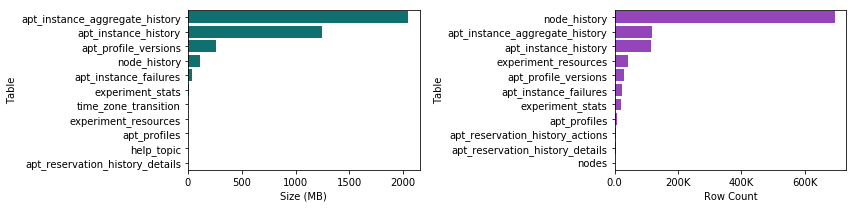

Total volume (MB): 3711

Processing: apt_instance_aggregate_history
	Saved dataframe (rows: 116924) with manifests to: manifests.csv
	*****
	Removing column (mostly NA): started
	*****
	*****
	Removing column (mostly NA): last_retry
	*****
	*****
	Removing column (anonymization, general): manifest
	*****
	*****
	Removing column (anonymization, general): public_url
	*****
	*****
	Removing column (anonymization, general): webtask_id
	*****
	*****
	Hashed column: name (XXX->8C05B8E610,XXX->8C05B8E610,XXX->31060D5C1E,XX -- OK (Removed NA: 8))
	*****
	uuid	(e452adbe-76bc-11e6-ac8b-90e2ba22fee4,6653e953-9f02) (NA: 0)
	name	(35DF1DFB7C,A76439BB90,7639A5C360,6511D554F8,90673C) (NA: 0)
	aggregate_urn	(urn:publicid:IDN+emulab.net+authority+cm,urn:publi) (NA: 0)
	status	(ready,terminated,terminated,ready,ready) (NA: 0)
	physnode_count	(0,2,0,0,30) (NA: 0)
	virtnode_count	(0,0,0,0,0) (NA: 0)
	retry_count	(0,0,0,0,0) (NA: 0)
	name-hash	(A67F279BF0,D0C1ACA8E0,A322891E47,61C5A93670,2CAC98) (NA: 0)
Sa

	*****
	Hashed column: uid (XXX->62BA1FA5FD,XXX->3D2D36AE5A,XXX->3EFDD566FC,XX -- OK (Removed NA: 0))
	*****
Saved staff hashes (rows: 6) to csv
	*****
	Removing column (anonymization, general): pid
	*****
	*****
	Removing column (anonymization, general): reason
	*****
	*****
	Hashed column: uid (XXX->E6C89352E0,XXX->59E68B4097,XXX->59E68B4097,XX -- OK (Removed NA: 0))
	*****
	idx	(4707,2837,17,2365,1562) (NA: 0)
	aggregate_urn	(urn:publicid:IDN+utah.cloudlab.us+authority+cm,urn) (NA: 0)
	reservation_uuid	(9c6a0b00-f31f-11e8-9331-90e2ba22fee4,None,None,66d) (NA: 2229)
	pid_idx	(11913,11285,13170,10108,13474) (NA: 0)
	uid	(FA30C0CCC6,66ABA7AE43,6729EB2948,370046E66F,FA30C0) (NA: 0)
	uid_idx	(278777,191710,270794,67122,132353) (NA: 0)
	stamp	(2018-04-30 21:46:18,2019-03-29 15:31:30,2019-01-30) (NA: 0)
	nodes	(10,21,1,4,1) (NA: 0)
	type	(c4130,m510,d820,d430,d430) (NA: 0)
	start	(NaT,2018-11-21 02:00:00,2018-10-03 05:00:00,2018-0) (NA: 187)
	end	(2018-12-21 17:00:00,2019-04-06 08:00:00,20

In [24]:
import pandas as pd
import mysql.connector as sql
import configparser
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mticker
import re
import hashlib
import time
import os

def query_sanitize(query):
    """ Sanitize given query before further processing """
    return ' '.join(query.rstrip("; ").lower().split())

def connect(config_file='db.ini'):
    config = configparser.ConfigParser()
    config.read([config_file])
    try:
        conn = sql.connect(host=config['connection']['host'],
                            port=config['connection']['port'],
                            database=config['connection']['db'],
                            user=config['connection']['user'],
                            password=config['connection']['pass'],)
    except sql.Error as e:
        print("Something went wrong when establishing database connection:\n{}".format(e))
        return None
    return conn

def get_tables(conn):
    cursor = conn.cursor()
    cursor.execute("SHOW TABLES;")
    return [str(x[0]) for x in cursor.fetchall()]

def get_tables_and_sizes(conn):
    
    # Example: https://chartio.com/resources/tutorials/how-to-get-the-size-of-a-table-in-mysql/
    q = """SELECT
      TABLE_SCHEMA AS `Database`,
      TABLE_NAME AS `Table`,
      ROUND((DATA_LENGTH + INDEX_LENGTH) / 1024 / 1024) AS `Size (MB)`
    FROM
      information_schema.TABLES
    ORDER BY
      (DATA_LENGTH + INDEX_LENGTH)
    DESC;"""
    cursor = conn.cursor()
    cursor.execute(q)
    return cursor.fetchall()
    
def get_tables_and_lengths(conn):
    cursor = conn.cursor()
    cursor.execute("SHOW TABLES;")
    
    res = []
    for t in [str(x[0]) for x in cursor.fetchall()]:
        cursor.execute("SELECT COUNT(*) FROM %s;" % t)
        res.append([t, int(cursor.fetchall()[0][0])])
        
    return res

def query2df(conn, query, limit=None):
    if isinstance(limit, int) and "limit" not in query_mod:
        df = pd.read_sql(query + " limit %d;" % limit, con=conn)
    else:
        df = pd.read_sql(query, con=conn)
    return df

def hash_and_describe(df, col, salt, hash_lenght = 10):
    
    val_count = 5
    
    # Original values -- used to be printed for debug, now hidden
    #val_before = df[col][:val_count].tolist()
    val_before = ["XXX"] * val_count
    
    if salt:
        df[col + "-hash"] = df[col].apply(lambda x: hashlib.md5(salt + x).hexdigest()[:hash_lenght].upper() if x else None)
    else:
        df[col + "-hash"] = df[col].apply(lambda x: hashlib.md5(x).hexdigest()[:hash_lenght].upper() if x else None)
    
    # Drop NA
    removed_na_count = df[col + "-hash"].isna().sum()
    df.drop(df[df[col + "-hash"].isna()].index, inplace=True)
    
    nunique_before = df[col].nunique()
    df[col] = df[col + "-hash"]
    val_after = df[col][:val_count].tolist()
    
    nunique_after = df[col].nunique()
    
    if nunique_before == nunique_after:
        check_res = "OK (Removed NA: %d)" % removed_na_count
    else:
        check_res = """\n\n-----------COLLISION FOUND 
        (Before: %d, After: %d)-----------\n\n""" % (nunique_before, nunique_after)
    
    print "\t*****\n\tHashed column: %s (%s -- %s)\n\t*****" % (col, 
                                                         ",".join(["%s->%s" % (str(b),str(a)) for b,a in \
                                                              zip(val_before, val_after)])[:50],
                                                               check_res)
    
def preprocess(df, t, salt):
    
    # Remove non-ASCII chars
    df.replace({r'[^\x00-\x7F]+':''}, regex=True, inplace=True)
    
    # Special processing for table with manifests
    if t == "apt_instance_aggregate_history":
        man_dest = "manifests.csv"
        df[["uuid", "manifest"]].to_csv("data/%s" % man_dest, index=False)
        print "\tSaved dataframe (rows: %d) with manifests to: %s" % (len(df), man_dest)
        
    # Special processing for apt_reservation_history_details
    # (save hashes for staff accounts' UIDs; this will allow excluding staff/testing reservations when analyzing usage)
    if t == "apt_reservation_history_details":
        if "uid" in df.columns: 
            staff_uid = pd.DataFrame(["stoller", "mike", "dreading", \
                                                               "ricci", "johnsond", "gtw"], \
                                                              columns=["uid"])
            staff_uid_hashes = staff_uid.copy()
            hash_and_describe(staff_uid_hashes, "uid", salt)
            staff_uid_hashes.uid = staff_uid.uid
            staff_uid_hashes.to_csv("data/staff_hashes.csv", index=False)
            print "Saved staff hashes (rows: %d) to csv" % (len(staff_uid_hashes))
    
    # Drop columns with small number of non-NA (i.e. meaningful) values
    na_thresh = 50
    for c in df.columns:
        if len(df) - df[c].isna().sum() <= na_thresh:
            print "\t*****\n\tRemoving column (mostly NA): %s\n\t*****" % c 
            df.drop([c], axis=1, inplace=True)

    # Drop columns with a single unique value
    # geniflags is an exception; keep it for processing in analysis notebooks
    for c in df.columns:
        if df[c].nunique() == 1 and c != "geniflags":
            
            print "\t*****\n\tRemoving column (single value): %s\n\t*****" % c 
            df.drop([c], axis=1, inplace=True)
    
    # Delete and hash common columns across all tables 
    for delete_c in ["creator", "updater", "pid", "gid", "eid", "manifest", "rspec", "script", "repourl",
                    "tarballs", "startupcmd", "public_url", "webtask_id", "reporef", "repohash",
                    "paramdefs", "reason", "nonlocal_id", "nonlocal_user_id",
                    "def_boot_osid", "def_boot_osid_vers", "def_boot_cmd_line", "priority", "ipodhash",
                    "ipport_low", "ipport_next", "ipport_high", "reservation_name", "sshdport", "servername"]:
        if (delete_c in df.columns):
            print "\t*****\n\tRemoving column (anonymization, general): %s\n\t*****" % delete_c
            df.drop([delete_c], axis=1, inplace=True)     
            
    for hash_c in ["name"]:
        if (hash_c in df.columns):
            hash_and_describe(df, hash_c, salt)
    
    # Table-specific anonymizations
    # List of table & column combinations to be deleted
    to_delete = []
    for delete_t, delete_c in to_delete:
        if (t == delete_t) and (delete_c in df.columns):
            print "\t*****\n\tRemoving column (anonymization, table-specific): %s\n\t*****" % delete_c
            df.drop([delete_c], axis=1, inplace=True)
    
    # List of table & column combinations to be hashed
    to_hash = [("apt_reservation_history_details", "uid")]
    for hash_t, hash_c in to_hash:
        if (t == hash_t) and (hash_c in df.columns):
            hash_and_describe(df, hash_c, salt)

    # Print info about the rest of the columns
    for c in df.columns:
        print "\t%s\t(%s) (NA: %s)" % (c, ",".join([str(v) for v in \
                                                    df[c].sample(5).tolist()]).replace("\n"," ")[:50], 
                                       df[c].isna().sum())
    
    return df

# Salt for hashing -- usencurrent time string
salt = str(time.time()).encode('utf-8')

conn = connect('db.ini')
if conn:
    t = get_tables(conn)
    l = get_tables_and_lengths(conn)
    s = get_tables_and_sizes(conn)
    
    # Visualize used space and number of records by table
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,3))
    t_sizes = pd.DataFrame(s, columns=["Database", "Table", "Size (MB)"]) 
    t_sizes = t_sizes[t_sizes["Size (MB)"]>0]
    sns.barplot(x='Size (MB)', y='Table', data=t_sizes, orient="h", color="teal", ax=ax1)
    t_lengths = pd.DataFrame(l, 
                             columns=["Table", "Row Count"]).sort_values("Row Count", ascending=False)
    ax = sns.barplot(x="Row Count", y="Table", data=t_lengths, orient="h", color="darkorchid", ax=ax2)
    # Replace 000 with K in axis tick labels
    ax2.xaxis.set_major_formatter(mticker.FuncFormatter(
        lambda x, pos: str(int(float(x)/1000)) + "K" if str(int(x)).endswith("000") else x))
    fig.tight_layout()
    plt.show()
    
    print "Total volume (MB):", t_sizes['Size (MB)'].sum()
    
    for x in t:        
        # Process nodes table differently (one cluster at a time); see the code at the end of the notebook 
        if x == "nodes":
            continue
        
        print "\nProcessing:", x
        raw_df = query2df(conn, "select * from %s" % x)
        df = preprocess(raw_df, x, salt)
        
        df.to_csv("data/%s.csv" % x, index=False)
        print "Saved table %s (rows: %d) to csv" % (x, len(df))
    
    conn.close()
    print "Done!"

In [5]:
!ls -lah data/

total 2.2G
drwxrwxrwx 2 dmdu  dmdu 4.0K May  8 16:16 .
drwxrwxr-x 5 ricci dmdu 4.0K May  8 16:14 ..
-rw-rw-r-- 1 dmdu  dmdu  14M May  8 16:09 apt_instance_aggregate_history.csv
-rw-rw-r-- 1 dmdu  dmdu  30M May  8 16:09 apt_instance_failures.csv
-rw-rw-r-- 1 dmdu  dmdu  31M May  8 16:10 apt_instance_history.csv
-rw-rw-r-- 1 dmdu  dmdu  66K May  8 15:14 apt_nodes.csv
-rw-rw-r-- 1 dmdu  dmdu 4.3M May  8 16:11 apt_profile_versions.csv
-rw-rw-r-- 1 dmdu  dmdu 957K May  8 16:11 apt_profiles.csv
-rw-rw-r-- 1 dmdu  dmdu 461K May  8 16:11 apt_reservation_history_actions.csv
-rw-rw-r-- 1 dmdu  dmdu 544K May  8 16:11 apt_reservation_history_details.csv
-rw-rw-r-- 1 dmdu  dmdu 100K May  8 15:15 clemson_nodes.csv
-rw-rw-r-- 1 dmdu  dmdu 258K May  8 15:16 emulab_nodes.csv
-rw-rw-r-- 1 dmdu  dmdu 4.0M May  8 16:11 experiment_resources.csv
-rw-rw-r-- 1 dmdu  dmdu 4.2M May  8 16:11 experiment_stats.csv
-rw-rw-r-- 1 dmdu  dmdu 2.1G May  8 16:09 manifests.csv
-rw-rw-r-- 1 dmdu  dmdu  38M May  8 16:11 nod

In [6]:
# Example of code for inspecting values in specified table & column

# t = "experiment_stats"
# c = "geniflags"

# conn = connect('db.ini')
# if conn:    
#     df = query2df(conn, "select * from %s" % t)
#     #print "\n".join([str(x) for x in df[c][~df[c].isna()].sample(500).tolist()])   
#     print df[c].unique()

### Use code below to save node tables for each of the clusters

In [7]:
# First, update db.ini to connect to the right db; 
# second, update the name of the output file to reflect the contents of the nodes table 

conn = connect('db.ini')
if conn:    
    df = query2df(conn, "select * from %s" % "nodes")
    
    df.to_csv("data/utah_nodes.csv", index=False)
    print "Saved dataframe (rows: %d)" % (len(df))

Saved dataframe (rows: 861)


In [23]:
# Combine individual csv files with node info into one aggregate dataframe and save it as csv after preprocessing

nodes_all = []
for f in os.listdir("data/"):
    if "_nodes.csv" in f:
        df = pd.read_csv("data/%s" % f, low_memory=False)  
        nodes_all.append(df)
        
nodes_all = preprocess(pd.concat(nodes_all), "nodes", salt)
#display(nodes_all)

df_dest = "nodes.csv"
nodes_all.to_csv("data/%s" % (df_dest), index=False)
print "Saved dataframe (rows: %d) with manifests to: %s" % (len(nodes_all), df_dest)

	*****
	Removing column (mostly NA): def_boot_path
	*****
	*****
	Removing column (mostly NA): def_boot_cmd_line
	*****
	*****
	Removing column (mostly NA): temp_boot_osid
	*****
	*****
	Removing column (mostly NA): next_boot_path
	*****
	*****
	Removing column (mostly NA): next_boot_cmd_line
	*****
	*****
	Removing column (mostly NA): pxe_boot_path
	*****
	*****
	Removing column (mostly NA): next_pxe_boot_path
	*****
	*****
	Removing column (mostly NA): rpms
	*****
	*****
	Removing column (mostly NA): deltas
	*****
	*****
	Removing column (mostly NA): loadlist
	*****
	*****
	Removing column (mostly NA): status_timestamp
	*****
	*****
	Removing column (mostly NA): jailip
	*****
	*****
	Removing column (mostly NA): jailipmask
	*****
	*****
	Removing column (mostly NA): sfshostid
	*****
	*****
	Removing column (mostly NA): stated_tag
	*****
	*****
	Removing column (mostly NA): cd_version
	*****
	*****
	Removing column (mostly NA): battery_voltage
	*****
	*****
	Removing column (mostly NA